In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks

 assets.zip				'Image Classifier Project (1).ipynb'
 cat_to_name.zip			'Image Classifier Project (2).ipynb'
 challenge_project_1.ipynb		 Untitled
'Copy of challenge_project_1.ipynb'	 Untitled0.ipynb
 flower_data.zip			 Untitled1.ipynb
'Image Classifier Project_1_0_0.ipynb'


In [3]:
!pip3 install torch==0.4.0
!pip3 install torchvision
!pip3 install numpy
!pip3 install matplotlib
!pip3 install Pillow==5.4.0
import PIL 
print(PIL.PILLOW_VERSION)


  Using cached https://files.pythonhosted.org/packages/69/43/380514bd9663f1bf708abeb359b8b48d3fabb1c8e95bb3427a980a064c57/torch-0.4.0-cp36-cp36m-manylinux1_x86_64.whl
tcmalloc: large alloc 1073750016 bytes == 0x5c0ce000 @  0x7f222e9152a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
  Found existing installation: torch 0.4.1
    Uninstalling torch-0.4.1:
      Successfully uninstalled torch-0.4.1
5.4.0


In [8]:
!unzip /content/gdrive/My\ Drive/Colab\ Notebooks/assets.zip

Archive:  /content/gdrive/My Drive/Colab Notebooks/assets.zip
replace assets/Flowers.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [9]:
!unzip /content/gdrive/My\ Drive/Colab\ Notebooks/cat_to_name.zip

Archive:  /content/gdrive/My Drive/Colab Notebooks/cat_to_name.zip
replace cat_to_name.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [10]:
!unzip /content/gdrive/My\ Drive/Colab\ Notebooks/flower_data.zip

Archive:  /content/gdrive/My Drive/Colab Notebooks/flower_data.zip
replace flower_data/valid/61/image_06296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [12]:
import os
items = os.listdir('/content')
print (items)

['.config', 'cat_to_name.json', 'checkpoint_one_layer_no_dropout.pth', 'checkpoint_two_layers.pth', 'checkpoint_model.pth', 'assets', '.ipynb_checkpoints', 'gdrive', 'checkpoint.pth', 'flower_data', 'sample_data']


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

![](/content/assets/inference_example.png)

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Imports here
import torch
import numpy as np 
from torch import nn 
import torch.nn.functional as F
# Load transforms from torchvision 
import torchvision.transforms as transforms 
# Loader datasets and models 
from torchvision import datasets, models
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
# Import the optimizer 
from torch import optim 
# Import the learn rate scheduler 
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
plt.ion()
import PIL
from PIL import Image
print(PIL.PILLOW_VERSION)
import time
import os
import copy
print(torch.__version__)

5.4.0
0.4.0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda:0")

CUDA is available!  Training on GPU ...


In [0]:
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(15),
                                      transforms.RandomGrayscale(0.15),
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
# Define a Test Transform
valid_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

In [0]:
# Let's split the validation data in 2 for test and training 
num_workers = 2 
# Percentage of data to be used for training and test 
test_size = 0.2 
# Lets get the indices
num_train = len(train_data)
# batch size 
batch_size = 32
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

# define the samples for train and test data 
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [0]:
# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,
                                          sampler=test_sampler)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)

dataloaders = { 'train': train_loader , 
                 'val': valid_loader }

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

tensor([  7,  94,   8,  18])


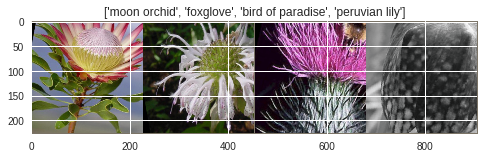

In [9]:
train_loader_batch_4 = torch.utils.data.DataLoader(train_data, batch_size=4,
                                           num_workers=num_workers, sampler=train_sampler)
# Lets visualize a couple of images 
def show_img(input_tensor, title=None):
    inp = input_tensor.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array( [0.229, 0.224, 0.225])
    inp = std * inp + mean 
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None: 
        plt.title(title)
    plt.pause(0.002)
    
class_names = train_data.classes
# get a batch 
inputs, classes = next(iter(train_loader_batch_4))
print(classes)
# making a grid 
out = torchvision.utils.make_grid(inputs)
show_img(out, title=[cat_to_name[str(x.numpy())] for x in classes])

In [10]:
# get number of classes 
qty_classes = len(cat_to_name)
print(qty_classes)

102


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# TODO: Build and train your network
model = models.resnet152(pretrained=True)
#model

### Finetuning the CNN 

In order to use our own classifier we need to freeze the first layers of the pretrained network, and change the last layer to adapt it for our own classifier and classes. 

In [0]:
# Freezing the parameters 
for param in model.parameters():
    param.requires_grad = False

In [13]:
num_ftrs = model.fc.in_features
print(num_ftrs)

# override the fully connected layer

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 1024)),
    ('relu', nn.ReLU(True)),
    ('fc2',nn.Linear(1024,qty_classes)),
    ('softmax', nn.LogSoftmax(dim=1))
]))

model.fc = classifier

2048


In [0]:
# Unfreeze the parameters before training
for param in model.parameters():
    param.requires_grad = True

In [15]:
# Print the new Classifier
model.fc

Sequential(
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (relu): ReLU(inplace)
  (fc2): Linear(in_features=1024, out_features=102, bias=True)
  (softmax): LogSoftmax()
)

In [0]:
# Define our Activation function 
criterion = nn.NLLLoss()
criterion.cuda()
# Use SGD as optimizer 
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# Define also a Learn rate scheduler which will be adjusted based on the epochs 
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)


In [0]:
def train_model(epochs=20): 

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # set the model to train value
    model.train()
    model.cuda()

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
        
        running_loss = 0.0
        running_correct = 0.0 
        #### Train the model ####
        for inputs, labels in train_loader:
          # update parameters with the the learn rate scheduler
          model.train()
          
          inputs, labels = inputs.cuda(), labels.cuda()
          # apply the zero_grad to clear the gradients 
          optimizer.zero_grad()
          
          with torch.set_grad_enabled(True):
            # apply forward function 
            outputs = model.forward(inputs)
            _, pred = torch.max(outputs, 1)
            # calculate the loss 
            loss = criterion(outputs, labels)
          
            # backpropagate 
            loss.backward() 

            # apply the optimizer and update the running loss 
            optimizer.step()            
            
            running_loss += loss.item() * inputs.size(0)
            running_correct += torch.sum(pred == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_correct.double() / len(train_loader.dataset)

        print('{} phase Loss: {:.6f} Acc: {:.6f}'.format( 'Training', epoch_loss, epoch_acc))    
        
        #### Validate the model #### 
        model.eval()
        running_loss = 0.0
        running_correct = 0.0 
        for data, labels in valid_loader:
          data, labels = data.cuda(), labels.cuda()
          
          # apply the zero_grad to clear the gradients 
          optimizer.zero_grad()            
          
          with torch.set_grad_enabled(False):
            outputs = model(data)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            if best_acc >= 0.90:
              scheduler.step(loss)
          
            running_loss += loss.item() * inputs.size(0)
            running_correct += torch.sum(pred == labels.data)
          
        epoch_loss = running_loss / len(valid_loader.dataset)
        epoch_acc = running_correct.double() / len(valid_loader.dataset)

        print('{} phase Loss: {:.6f} Acc: {:.6f}'.format( 'Validation', epoch_loss, epoch_acc))           

        if epoch_acc > best_acc:
          print("Found better accuraccy ({:.6f} ---> {:.6f}). Saving weights..".format(best_acc, epoch_acc))
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    print('Best val Acc: {:6f}'.format(best_acc))        
    return best_model_wts    
     

In [18]:
# train the model with 20 epochs 
best_model = train_model(20)

Epoch 1/20
----------
Training phase Loss: 3.477025 Acc: 0.089896
Validation phase Loss: 3.287024 Acc: 0.176039
Found better accuraccy (0.000000 ---> 0.176039). Saving weights..

Epoch 2/20
----------
Training phase Loss: 2.805855 Acc: 0.222375
Validation phase Loss: 2.511300 Acc: 0.382641
Found better accuraccy (0.176039 ---> 0.382641). Saving weights..

Epoch 3/20
----------
Training phase Loss: 2.137463 Acc: 0.371795
Validation phase Loss: 1.852519 Acc: 0.556235
Found better accuraccy (0.382641 ---> 0.556235). Saving weights..

Epoch 4/20
----------
Training phase Loss: 1.598822 Acc: 0.484890
Validation phase Loss: 1.311234 Acc: 0.689487
Found better accuraccy (0.556235 ---> 0.689487). Saving weights..

Epoch 5/20
----------
Training phase Loss: 1.198801 Acc: 0.577076
Validation phase Loss: 0.914914 Acc: 0.778729
Found better accuraccy (0.689487 ---> 0.778729). Saving weights..

Epoch 6/20
----------
Training phase Loss: 0.900713 Acc: 0.640873
Validation phase Loss: 0.659802 Acc: 0.

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
checkpoint = {'input_size': 2048,
              'output_size': 102,
              'state_dict': best_model,
              'optimizer_state': optimizer.state_dict(),
              'epochs': 20,
              'class_to_idx': train_data.class_to_idx,
              'architecture': models.resnet152(pretrained=True),
              'fc': model.fc,
              'batch_size': 32
             }

torch.save(checkpoint, 'checkpoint_040.pth')

In [36]:
!ls -lth checkpoint_040_1*

-rw-r--r-- 1 root root 700M Jan  5 00:12 checkpoint_040_1.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [1]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['architecture']
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    epochs = checkpoint['epochs']
    model.class_to_idx = checkpoint['class_to_idx']
    model.fc = checkpoint['fc']

    return model

model_1 = load_checkpoint('checkpoint_040.pth')
model_1.fc
idx_to_class = { v : k for k,v in model_1.class_to_idx.items()}

NameError: ignored

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(img_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(img_path)
    
    transform = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    image_tensor = transform(img)
    
    return image_tensor



In [24]:
img_path = "flower_data/train/10/image_07089.jpg"
img = process_image(img_path)
print(img.shape)

torch.Size([3, 224, 224])


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

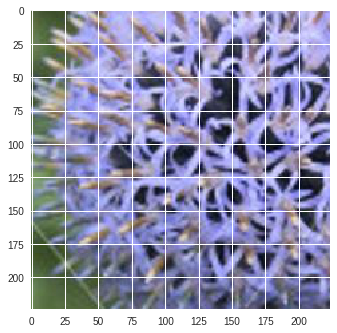

In [26]:
# Test image has been processed correctly
imshow(img)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.cuda()
    # let us process the image 
    img = process_image(image_path)
    # Convert 2D image to 1D vector
    image = img.unsqueeze_(0)

    # Calculate the class probabilities (softmax) for img
    with torch.no_grad():
      model.eval()
      output = model.forward(image.cuda())
      possibilities, predicted = torch.topk(output, topk)
    
    ps = F.softmax(possibilities,dim=1)
    
    return ps, predicted

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
def update_labels(classes):
  labels = []
  
  for x in classes.cpu().numpy():
    for y in x:
      labels.append(cat_to_name[idx_to_class[y]])
  
  return labels

In [0]:
# TODO: Display an image along with the top 5 classes
def check(img, ps, classes):
    ps = ps.data.numpy().squeeze()
    
    img = Image.open(img)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(np.arange(5), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    
    ax2.set_yticklabels(np.arange(5))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    ax2.set_yticklabels(update_labels(classes))

    plt.tight_layout()
    
  

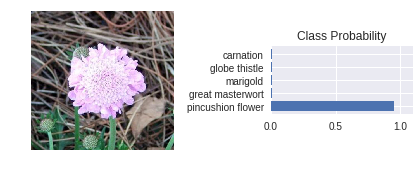

In [33]:
img_path = "flower_data/train/22/image_05340.jpg" 
probs, preds = predict(img_path,model_1)
check(img_path, probs.cpu(), preds.cpu())
